In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import networkx as nx
import numpy as np

%matplotlib inline

import logging

logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

In [3]:
from scipy.spatial.distance import squareform
import seaborn as sns

In [44]:
num_nodes = 64
embed_dims = [2, 5, 10, 20, 30, 40]
num_embed_dims = len(embed_dims)

embed_types = ['Euclidean', 'Hyperbolic', 'WassR2', 'WassR3', 'KL']
num_embed_types = len(embed_types)

loss_reg = np.zeros((num_embed_types, num_embed_dims, 10))
time_reg = np.zeros((num_embed_types, num_embed_dims, 8))

time_graphs = [1, 3, 5, 6, 7, 8, 9, 10]

embeddings = []
embed_distances = []

for graph_id in range(10):
    for i, embed_type in enumerate(embed_types):
        for j, embed_dim in enumerate(embed_dims):
            res = np.load('./results/scale_free_{}_{}_{}_{}.npz'.format(num_nodes, graph_id+1, embed_type, embed_dim))
            loss_history = res['loss']
            loss = loss_history[-1]
            loss_reg[i, j, graph_id] = loss
            
            if graph_id == 0 and embed_dim == 40:
                embeddings.append(res['embeddings'])
                embed_distances.append(res['embed_distances'])
            
for g, graph_id in enumerate(time_graphs):
    for i, embed_type in enumerate(embed_types):
        for j, embed_dim in enumerate(embed_dims):
            res = np.load('./results/scale_free_{}_{}_{}_{}.npz'.format(num_nodes, graph_id, embed_type, embed_dim))
            time_history = res['time']
            t = time_history[-1]
            time_reg[i, j, g] = t

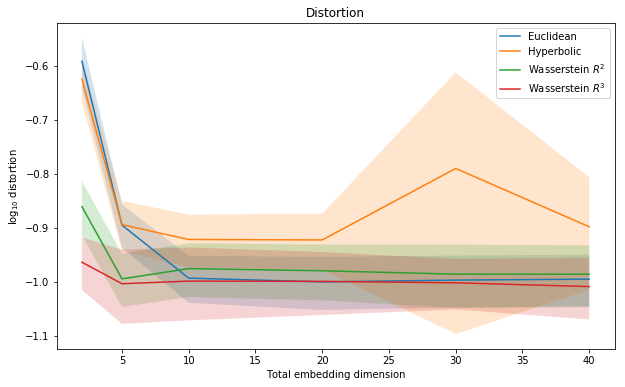

In [42]:
Euc_loss, Hyper_loss, WassR2_loss, WassR3_loss, KL_loss = loss_reg

mean_Euc_loss = np.mean(Euc_loss, axis=-1)
std_Euc_loss = np.std(Euc_loss, axis=-1)
upper_confidence_Euc = mean_Euc_loss + 1.96 * std_Euc_loss
lower_confidence_Euc = mean_Euc_loss - 1.96 * std_Euc_loss

mean_Hyper_loss = np.mean(Hyper_loss, axis=-1)
std_Hyper_loss = np.std(Hyper_loss, axis=-1)
upper_confidence_Hyper = mean_Hyper_loss + 1.96 * std_Hyper_loss
lower_confidence_Hyper = mean_Hyper_loss - 1.96 * std_Hyper_loss

mean_WassR2_loss = np.mean(WassR2_loss, axis=-1)
std_WassR2_loss = np.std(WassR2_loss, axis=-1)
upper_confidence_WassR2 = mean_WassR2_loss + 1.96 * std_WassR2_loss
lower_confidence_WassR2 = mean_WassR2_loss - 1.96 * std_WassR2_loss

mean_WassR3_loss = np.mean(WassR3_loss, axis=-1)
std_WassR3_loss = np.std(WassR3_loss, axis=-1)
upper_confidence_WassR3 = mean_WassR3_loss + 1.96 * std_WassR3_loss
lower_confidence_WassR3 = mean_WassR3_loss - 1.96 * std_WassR3_loss

mean_KL_loss = np.mean(KL_loss, axis=-1)
std_KL_loss = np.std(KL_loss, axis=-1)
upper_confidence_KL = mean_KL_loss + 1.96 * std_KL_loss
lower_confidence_KL = mean_KL_loss - 1.96 * std_KL_loss

# plt.figure(figsize=(10, 6))
_, ax = plt.subplots(figsize=(10, 6))
ax.plot(embed_dims, np.log10(mean_Euc_loss), label='Euclidean')
ax.fill_between(embed_dims, np.log10(upper_confidence_Euc), np.log10(lower_confidence_Euc), alpha=0.2)
ax.plot(embed_dims, np.log10(mean_Hyper_loss), label='Hyperbolic')
ax.fill_between(embed_dims, np.log10(upper_confidence_Hyper), np.log10(lower_confidence_Hyper), alpha=0.2)
ax.plot(embed_dims, np.log10(mean_WassR2_loss), label='Wasserstein $R^2$')
ax.fill_between(embed_dims, np.log10(upper_confidence_WassR2), np.log10(lower_confidence_WassR2), alpha=0.2)
ax.plot(embed_dims, np.log10(mean_WassR3_loss), label='Wasserstein $R^3$')
ax.fill_between(embed_dims, np.log10(upper_confidence_WassR3), np.log10(lower_confidence_WassR3), alpha=0.2)
# ax.plot(embed_dims, np.log10(mean_KL_loss), label='KL')
# ax.fill_between(embed_dims, np.log10(upper_confidence_KL), np.log10(lower_confidence_KL), alpha=0.4)
ax.set_xlabel('Total embedding dimension')
ax.set_ylabel('$\log_{10}$ distortion')
ax.set_title('Distortion')
ax.legend(loc='best')
# plt.show()

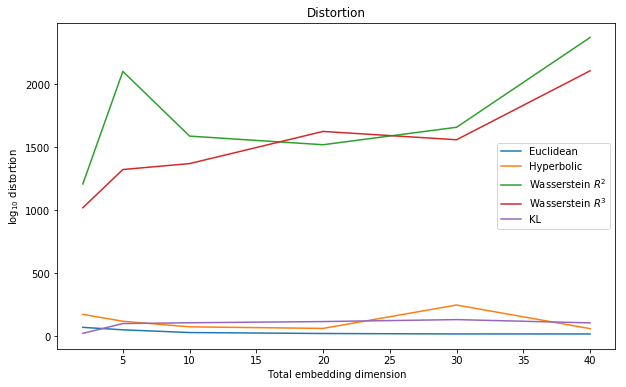

In [39]:
Euc_time, Hyper_time, WassR2_time, WassR3_time, KL_time = time_reg

mean_Euc_time = np.mean(Euc_time, axis=-1)
# std_Euc_time = np.std(Euc_time, axis=-1)
# upper_confidence_Euc_time = mean_Euc_time + 1.96 * std_Euc_time
# lower_confidence_Euc_time = mean_Euc_time - 1.96 * std_Euc_time

mean_Hyper_time = np.mean(Hyper_time, axis=-1)
# std_Hyper_time = np.std(Hyper_time, axis=-1)
# upper_confidence_Hyper_time = mean_Hyper_time + 1.96 * std_Hyper_time
# lower_confidence_Hyper_time = mean_Hyper_time - 1.96 * std_Hyper_time

mean_WassR2_time = np.mean(WassR2_time, axis=-1)
# std_WassR2_time = np.std(WassR2_time, axis=-1)
# upper_confidence_WassR2_time = mean_WassR2_time + 1.96 * std_WassR2_time
# lower_confidence_WassR2_time = mean_WassR2_time - 1.96 * std_WassR2_time

mean_WassR3_time = np.mean(WassR3_time, axis=-1)
# std_WassR3_time = np.std(WassR3_time, axis=-1)
# upper_confidence_WassR3_time = mean_WassR3_time + 1.96 * std_WassR3_time
# lower_confidence_WassR3_time = mean_WassR3_time - 1.96 * std_WassR3_time

mean_KL_time = np.mean(KL_time, axis=-1)
# std_KL_time = np.std(KL_time, axis=-1)
# upper_confidence_KL_time = mean_KL_time + 1.96 * std_KL_time
# lower_confidence_KL_time = mean_KL_time - 1.96 * std_KL_time

# plt.figure(figsize=(10, 6))
_, ax = plt.subplots(figsize=(10, 6))
ax.plot(embed_dims, mean_Euc_time, label='Euclidean')
# ax.fill_between(embed_dims, np.log10(upper_confidence_Euc_time), np.log10(lower_confidence_Euc_time), alpha=0.2)
ax.plot(embed_dims, mean_Hyper_time, label='Hyperbolic')
# ax.fill_between(embed_dims, np.log10(upper_confidence_Hyper_time), np.log10(lower_confidence_Hyper_time), alpha=0.2)
ax.plot(embed_dims, mean_WassR2_time, label='Wasserstein $R^2$')
# ax.fill_between(embed_dims, np.log10(upper_confidence_WassR2_time), np.log10(lower_confidence_WassR2_time), alpha=0.2)
ax.plot(embed_dims, mean_WassR3_time, label='Wasserstein $R^3$')
# ax.fill_between(embed_dims, np.log10(upper_confidence_WassR3_time), np.log10(lower_confidence_WassR3_time), alpha=0.2)
ax.plot(embed_dims, mean_KL_time, label='KL')
# ax.fill_between(embed_dims, np.log10(upper_confidence_KL_time), np.log10(lower_confidence_KL_time), alpha=0.4)
ax.set_xlabel('Total embedding dimension')
ax.set_ylabel('$\log_{10}$ distortion')
ax.set_title('Distortion')
ax.legend(loc='best')
# plt.show()

In [40]:
print(WassR2_time[1])

[4550.49310231 1348.78217053 1524.97615123 3085.59770298 1247.21407223
 3188.33462811 1018.45252013  840.93476892]


In [43]:
print(Hyper_loss)
print(mean_Hyper_loss)
print(std_Hyper_loss)

[[0.23016718 0.23170158 0.23449094 0.22040994 0.24457028 0.25729468
  0.25054837 0.24408573 0.22387775 0.23300687]
 [0.12364459 0.12099129 0.13152485 0.11853406 0.12321941 0.14165117
  0.13623855 0.12598816 0.12298851 0.13076763]
 [0.11627717 0.11598575 0.12208297 0.10981759 0.11536472 0.13574923
  0.12553331 0.11687463 0.11691475 0.1228655 ]
 [0.11658864 0.11568751 0.12242705 0.10699567 0.1162902  0.13565285
  0.12543227 0.1162999  0.11663911 0.12304032]
 [0.1171594  0.11702903 0.12300137 0.23442741 0.118296   0.1362393
  0.20246475 0.18866867 0.18831877 0.19541971]
 [0.11771156 0.116387   0.12282771 0.16854498 0.11666979 0.13578787
  0.12694802 0.11803041 0.11723296 0.12392853]]
[0.23701533 0.12755482 0.11974656 0.11950535 0.16210244 0.12640688]
[0.01116858 0.00694293 0.00681902 0.00724779 0.04187053 0.01519214]


In [5]:
euc_10_2 = np.load('./results/scale_free_64_6_Euclidean_10.npz')
embeddings = euc_10_2['embeddings']
loss_history = euc_10_2['loss']
time_history = euc_10_2['time']
embed_distances = euc_10_2['embed_distances']

In [6]:
loss_history

array([0.5327335 , 0.42583855, 0.35543291, 0.32397707, 0.31634268,
       0.32182086, 0.32561219, 0.3198342 , 0.30542593, 0.28792896,
       0.27332844, 0.26300565, 0.25582913, 0.25097326, 0.24523601,
       0.23729847, 0.22802633, 0.21846963, 0.21030866, 0.20456473,
       0.20003271, 0.19514275, 0.18946682, 0.18304769, 0.17594908,
       0.16931514, 0.16386862, 0.15984021, 0.15599077, 0.15210828,
       0.14896501, 0.14625963, 0.14417243, 0.14209029, 0.13945118,
       0.13671198, 0.13419698, 0.1317296 , 0.12941428, 0.12786255,
       0.12674286, 0.12586012, 0.12470063, 0.12346456, 0.12266158,
       0.12195278, 0.12125632, 0.12058312, 0.11995166, 0.1192266 ,
       0.11846503, 0.11793328, 0.11751837, 0.11715263, 0.11666649,
       0.11633265, 0.11610216, 0.11582776, 0.11563778, 0.11548139,
       0.11512527, 0.11471244, 0.11450886, 0.11429263, 0.11421273,
       0.11408708, 0.11377841, 0.11355527, 0.11348836, 0.11339884,
       0.11321866, 0.11316087, 0.11300997, 0.11292841, 0.11282

In [45]:
from graph_generator import GraphGenerator

g = nx.read_gpickle("./graphs/scale_free_64_1.pickle")
node_pairs = g.get_node_pairs()
obj_distances = g.get_obj_distances()

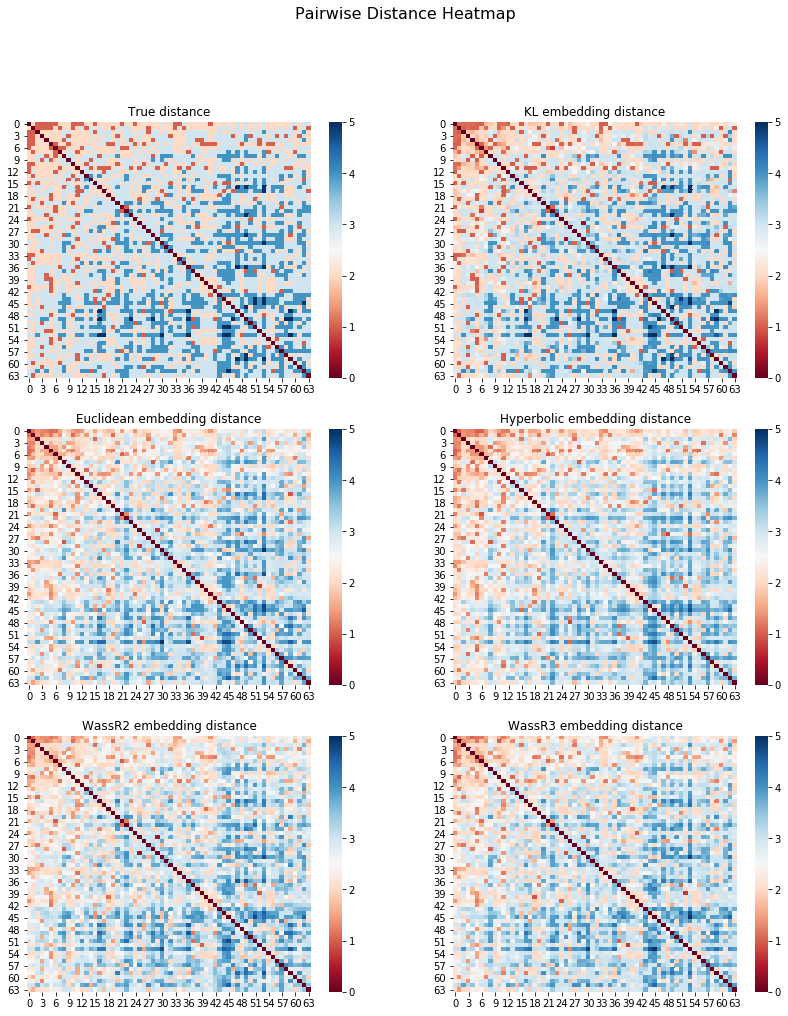

In [54]:
fig = plt.figure(figsize=(14, 16))
fig.suptitle("Pairwise Distance Heatmap", fontsize=16)

true_distance = squareform(obj_distances)
ax = plt.subplot(321)
ax.set_title('True distance')
sns.heatmap(true_distance, cmap='RdBu', vmin=0, vmax=int(round(true_distance.max())))

for i, _ in enumerate(embed_types):
    pred_distance = squareform(embed_distances[(i+4)%5])
    ax = plt.subplot(322+i)
    ax.set_title(embed_types[(i+4)%5] + " embedding distance")
    sns.heatmap(pred_distance, cmap='RdBu', vmin=0, vmax=int(round(true_distance.max())))

In [2]:
def cdist(X, Y):
    X2 = tf.reduce_sum(tf.square(X), 1)
    Y2 = tf.reduce_sum(tf.square(Y), 1)
    X2 = tf.reshape(X2, [-1, 1])
    Y2 = tf.reshape(Y2, [1, -1])
    # return pairwise euclidead difference matrix
    distances = tf.sqrt(tf.maximum(
        X2 + Y2 - 2 * tf.matmul(X, Y, False, True), 0.0))
    assert distances.shape == [X.shape[0], Y.shape[0]]
    return distances

In [3]:
def compute_T(K, u, v, n_iter, tol):
    """
    Parameters:
    -----------
        D: 2D array, [M, N]
        r: 1D array, [M, ]
        c: 1D array, [N, ]
        lambd: regularization parameter in Sinkhorn divergence
        p: power of the Wasserstein space
        n_iter: number of iterations for matrix balancing
        tol: tolerance for stopping matrix balancing iterations
    """
    K_tilde = 1. / u * K
    r = tf.random_normal([int(u.shape[0]), 1], dtype=tf.float64)
    r_new = tf.negative(tf.ones([int(u.shape[0]), 1], dtype=tf.float64))

    def cond(r, r_new):
        r_enter = tf.reduce_any(tf.abs(r_new - r) > tol)
        return r_enter

    def body(r, r_new):
        r = r_new
        r_new = 1. / tf.matmul(K_tilde, v / tf.matmul(K, r, True, False))
        return [r, r_new]

    _, r = tf.while_loop(cond, body, [r, r_new], maximum_iterations=n_iter)
    c = v / tf.matmul(K, r, True, False)

    T_opt = tf.matmul(tf.diag(tf.reshape(r, (-1,))),
                      tf.matmul(K, tf.diag(tf.reshape(c, (-1,)))))

    return T_opt

In [4]:
def wasserstein_distance(n1, n2, embeddings, u, v, lambd, p, n_iter, tol):
    support_1 = embeddings[n1, :, :]
    support_2 = embeddings[n2, :, :]
    D = cdist(support_1, support_2)
    D_p = tf.pow(D, p)
    K = tf.exp(-D_p / lambd)
    T = compute_T(K, u, v, n_iter, tol)

    # distance = tf.trace(tf.matmul(D_p, T, False, True)) + lambd * \
    #     tf.trace(tf.matmul(T, tf.log(T) -
    #                        tf.ones(T.shape, dtype=tf.float64), False, True))
    distance = tf.trace(tf.matmul(D_p, T, False, True))
    return distance

In [5]:
def wasserstein_distances(pairs, embeddings, u, v, lambd, p, n_iter, tol):
    results = tf.map_fn(lambda x: wasserstein_distance(
        x[0], x[1], embeddings, u, v, lambd, p, n_iter, tol), pairs, dtype=tf.float64)
    return results

In [6]:
def euclidean_distance(n1, n2, embeddings):
    v1 = embeddings[n1, :]
    v2 = embeddings[n2, :]
    distance = tf.sqrt(tf.reduce_sum(tf.square(v1 - v2)))
    return distance

In [7]:
def euclidean_distances(pairs, embeddings):
    results = tf.map_fn(lambda x: euclidean_distance(x[0], x[1], embeddings), pairs, dtype=tf.float64)
    return results

In [8]:
def hyperbolic_distance(n1, n2, embeddings, eps):
    v1 = embeddings[n1, :]
    v2 = embeddings[n2, :]
    norm1 = tf.norm(v1)
    norm2 = tf.norm(v2)
    v1 = tf.cond(tf.greater_equal(norm1, 1), lambda: v1 / norm1 - eps, lambda: v1)
    v2 = tf.cond(tf.greater_equal(norm2, 1), lambda: v2 / norm2 - eps, lambda: v2)
    
    distance = tf.acosh(1 + 2 * tf.reduce_sum(tf.square(v1 - v2)) / ((1 - tf.reduce_sum(tf.square(v1))) * (1 - tf.reduce_sum(tf.square(v2)))))
    return distance

In [9]:
def hyperbolic_distances(pairs, embeddings, eps):
    results = tf.map_fn(lambda x: hyperbolic_distance(x[0], x[1], embeddings, eps), pairs, dtype=tf.float64)
    return results

In [14]:
def train(node_pairs, obj_distances, embedding_type='Euc', n_epochs=500, patience=10, learning_rate=0.01, u_v=None, nodes=128, embed_dim=20, ground_dim=2, lambd=1.0, p=1, mat_bal_iter=20, mat_bal_tol=1e-5, eps=1e-5):
    if u_v is None:
        u = tf.ones([embed_dim, 1], dtype=tf.float64) / embed_dim
        v = tf.ones([embed_dim, 1], dtype=tf.float64) / embed_dim
    
    n_nodes = int(obj_distances.shape[0])

    Node_Pairs = tf.placeholder(dtype=tf.int32, shape=[n_nodes, 2], name='Node_Pairs')
    Obj_Distances = tf.placeholder(dtype=tf.float64, shape=[n_nodes], name='Obj_Distances')
    Lambd = tf.placeholder(dtype=tf.float64, shape=(), name='Lambd')
    Learning_rate = tf.placeholder(dtype=tf.float64, shape=(), name='Learning_rate')

    if (embedding_type == 'Wass'):
        Embeddings = tf.Variable(tf.random.uniform(
        [nodes, embed_dim, ground_dim], dtype=tf.float64), name='Embeddings')
        Embed_Distances = wasserstein_distances(Node_Pairs, Embeddings, u, v, Lambd, p, mat_bal_iter, mat_bal_tol)
    elif (embedding_type == 'Hyper'):
        Embeddings = tf.Variable(0.002 * tf.random.uniform([nodes, embed_dim], dtype=tf.float64) - 0.001, name='Embeddings')
        Embed_Distances = hyperbolic_distances(Node_Pairs, Embeddings, eps)
    else:
        Embeddings = tf.Variable(tf.random.uniform([nodes, embed_dim], dtype=tf.float64), name='Embeddings')
        Embed_Distances = euclidean_distances(Node_Pairs, Embeddings)

    Loss = tf.reduce_mean(tf.abs(Embed_Distances - Obj_Distances) / Obj_Distances)
    Jac = tf.gradients(ys=Embed_Distances, xs=Embeddings)
    optimizer = tf.train.AdamOptimizer(Learning_rate).minimize(Loss)
    init_op = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init_op)
        # Lists for storing the changing Cost and Accuracy in every Epoch
        loss_history = []

        best_loss = 1000
        early_stopping_counter = 0
        for epoch in range(n_epochs):
           # Running the Optimizer
            _, embeddings, embed_distances, loss, jac = sess.run([optimizer, Embeddings, Embed_Distances, Loss, Jac], feed_dict={Node_Pairs: node_pairs, Obj_Distances: obj_distances, Lambd: lambd, Learning_rate: learning_rate})
            # Storing loss to the history
            loss_history.append(loss)
            # Displaying result on current Epoch
            # if epoch % 10 == 0 and epoch != 0:
            logging.info("Epoch: {}/{}, loss: {}".format(epoch, n_epochs, loss))
            # Early stopping check
            if loss < best_loss:
                best_loss = loss
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
            if early_stopping_counter >= patience:
                break
    return embeddings, loss_history, embed_distances, jac

In [11]:
from graph_generator import GraphGenerator

In [12]:
# g = GraphGenerator(graph_type='scale-free', n_nodes=128, m=3)
g = nx.read_gpickle("./graphs/scale_free_1.pickle")
node_pairs = g.get_node_pairs()
print(node_pairs.shape)
obj_distances = g.get_obj_distances()
print(obj_distances.shape)

(8128, 2)
(8128,)


In [15]:
# embeddings, loss_history, embed_distances, jac = train(node_pairs, obj_distances, learning_rate=0.5, n_epochs=2000, patience=5, 
#                                                        embed_dim=15, lambd=1., mat_bal_iter=20)

# learning rate = 0.1 for Euc and Wass, 0.01 for Hyper
embeddings, loss_history, embed_distances, jac = train(node_pairs, obj_distances, embedding_type='Euclidean')

2019-04-25 21:24:09,958 - INFO - Epoch: 0/500, loss: 0.3514783017373753
2019-04-25 21:24:16,528 - INFO - Epoch: 1/500, loss: 0.3386964822115621
2019-04-25 21:24:22,772 - INFO - Epoch: 2/500, loss: 0.3270333269449108
2019-04-25 21:24:29,335 - INFO - Epoch: 3/500, loss: 0.3165756830583842
2019-04-25 21:24:35,500 - INFO - Epoch: 4/500, loss: 0.3072092658607278
2019-04-25 21:24:41,583 - INFO - Epoch: 5/500, loss: 0.29886128176543336
2019-04-25 21:24:48,076 - INFO - Epoch: 6/500, loss: 0.29144820479175226
2019-04-25 21:24:54,518 - INFO - Epoch: 7/500, loss: 0.28472881279899015
2019-04-25 21:25:02,411 - INFO - Epoch: 8/500, loss: 0.27862165865798794
2019-04-25 21:25:08,577 - INFO - Epoch: 9/500, loss: 0.2730498042519079
2019-04-25 21:25:15,287 - INFO - Epoch: 10/500, loss: 0.2678424111307508
2019-04-25 21:25:23,143 - INFO - Epoch: 11/500, loss: 0.26295400497666277
2019-04-25 21:25:29,303 - INFO - Epoch: 12/500, loss: 0.2584074748523195
2019-04-25 21:25:35,587 - INFO - Epoch: 13/500, loss: 0.

2019-04-25 21:38:16,750 - INFO - Epoch: 112/500, loss: 0.13661178551237405
2019-04-25 21:38:25,064 - INFO - Epoch: 113/500, loss: 0.13604333256695808
2019-04-25 21:38:33,289 - INFO - Epoch: 114/500, loss: 0.13548853705704483
2019-04-25 21:38:41,636 - INFO - Epoch: 115/500, loss: 0.13494184912329263
2019-04-25 21:38:50,057 - INFO - Epoch: 116/500, loss: 0.13440547465684047
2019-04-25 21:38:58,276 - INFO - Epoch: 117/500, loss: 0.13388151749607194
2019-04-25 21:39:06,572 - INFO - Epoch: 118/500, loss: 0.1333692595238743
2019-04-25 21:39:15,511 - INFO - Epoch: 119/500, loss: 0.13286988638487712
2019-04-25 21:39:23,656 - INFO - Epoch: 120/500, loss: 0.13237606697991572
2019-04-25 21:39:31,991 - INFO - Epoch: 121/500, loss: 0.13189235570437166
2019-04-25 21:39:40,110 - INFO - Epoch: 122/500, loss: 0.13141259956340387
2019-04-25 21:39:48,749 - INFO - Epoch: 123/500, loss: 0.1309431415534293
2019-04-25 21:39:57,755 - INFO - Epoch: 124/500, loss: 0.13048706845573918
2019-04-25 21:40:07,459 - I

2019-04-25 21:52:58,607 - INFO - Epoch: 222/500, loss: 0.1139768653180288
2019-04-25 21:53:05,061 - INFO - Epoch: 223/500, loss: 0.11393496032325252
2019-04-25 21:53:11,626 - INFO - Epoch: 224/500, loss: 0.11389670272045553
2019-04-25 21:53:17,930 - INFO - Epoch: 225/500, loss: 0.11385765679091563
2019-04-25 21:53:24,180 - INFO - Epoch: 226/500, loss: 0.11381705850180493
2019-04-25 21:53:30,418 - INFO - Epoch: 227/500, loss: 0.11377986379411487
2019-04-25 21:53:36,880 - INFO - Epoch: 228/500, loss: 0.11374265620195455
2019-04-25 21:53:43,467 - INFO - Epoch: 229/500, loss: 0.11370255255398506
2019-04-25 21:53:50,706 - INFO - Epoch: 230/500, loss: 0.11366563313159757
2019-04-25 21:53:57,443 - INFO - Epoch: 231/500, loss: 0.11363485388047499
2019-04-25 21:54:05,158 - INFO - Epoch: 232/500, loss: 0.11359679652611003
2019-04-25 21:54:11,468 - INFO - Epoch: 233/500, loss: 0.11356373365796857
2019-04-25 21:54:17,944 - INFO - Epoch: 234/500, loss: 0.11353044138419519
2019-04-25 21:54:24,726 - 

2019-04-25 22:05:07,357 - INFO - Epoch: 332/500, loss: 0.11192880383022868
2019-04-25 22:05:13,510 - INFO - Epoch: 333/500, loss: 0.1119299293058085
2019-04-25 22:05:19,657 - INFO - Epoch: 334/500, loss: 0.11192577183963764
2019-04-25 22:05:25,833 - INFO - Epoch: 335/500, loss: 0.11191760007458743
2019-04-25 22:05:31,918 - INFO - Epoch: 336/500, loss: 0.11191153996503432
2019-04-25 22:05:38,759 - INFO - Epoch: 337/500, loss: 0.11190580718103525
2019-04-25 22:05:45,033 - INFO - Epoch: 338/500, loss: 0.11189661742428687
2019-04-25 22:05:51,090 - INFO - Epoch: 339/500, loss: 0.11189474556573961
2019-04-25 22:05:57,135 - INFO - Epoch: 340/500, loss: 0.11188664580214039
2019-04-25 22:06:03,187 - INFO - Epoch: 341/500, loss: 0.11188400155726587
2019-04-25 22:06:09,242 - INFO - Epoch: 342/500, loss: 0.1118734092849336
2019-04-25 22:06:15,282 - INFO - Epoch: 343/500, loss: 0.11187236922584821
2019-04-25 22:06:21,394 - INFO - Epoch: 344/500, loss: 0.1118686216009958
2019-04-25 22:06:27,456 - IN

2019-04-25 22:17:36,552 - INFO - Epoch: 442/500, loss: 0.11165902257385678
2019-04-25 22:17:42,605 - INFO - Epoch: 443/500, loss: 0.11165620903836959
2019-04-25 22:17:48,592 - INFO - Epoch: 444/500, loss: 0.11165516052625675
2019-04-25 22:17:54,640 - INFO - Epoch: 445/500, loss: 0.11165772548090509
2019-04-25 22:18:00,702 - INFO - Epoch: 446/500, loss: 0.1116528619757196
2019-04-25 22:18:06,730 - INFO - Epoch: 447/500, loss: 0.1116482726366041
2019-04-25 22:18:12,780 - INFO - Epoch: 448/500, loss: 0.11164807124253202
2019-04-25 22:18:19,667 - INFO - Epoch: 449/500, loss: 0.11164553631977306
2019-04-25 22:18:25,944 - INFO - Epoch: 450/500, loss: 0.11165058089572749
2019-04-25 22:18:31,997 - INFO - Epoch: 451/500, loss: 0.11164451480516284
2019-04-25 22:18:38,486 - INFO - Epoch: 452/500, loss: 0.11164273873943657
2019-04-25 22:18:44,711 - INFO - Epoch: 453/500, loss: 0.11164145162258127
2019-04-25 22:18:50,828 - INFO - Epoch: 454/500, loss: 0.11163862264292261
2019-04-25 22:18:57,054 - I

In [13]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
%matplotlib inline

2019-04-24 22:56:15,534 - INFO - Epoch: 0/2000, loss: 0.8040404394726478
2019-04-24 22:56:52,682 - INFO - Epoch: 1/2000, loss: 0.6034714800583868
2019-04-24 22:57:48,663 - INFO - Epoch: 2/2000, loss: 0.4499510248187679
2019-04-24 22:59:09,616 - INFO - Epoch: 3/2000, loss: 0.3403253575284184
2019-04-24 23:00:46,814 - INFO - Epoch: 4/2000, loss: 0.30485341151240913
2019-04-24 23:02:26,899 - INFO - Epoch: 5/2000, loss: 0.3167307018549681
2019-04-24 23:04:23,898 - INFO - Epoch: 6/2000, loss: 0.33272539166453
2019-04-24 23:06:06,257 - INFO - Epoch: 7/2000, loss: 0.3287096588601522
2019-04-24 23:07:50,965 - INFO - Epoch: 8/2000, loss: 0.30559554644627057
2019-04-24 23:09:36,995 - INFO - Epoch: 9/2000, loss: 0.272938868059585
2019-04-24 23:11:24,933 - INFO - Epoch: 10/2000, loss: 0.24294083170009656
2019-04-24 23:13:19,853 - INFO - Epoch: 11/2000, loss: 0.22428116925997382
2019-04-24 23:15:36,981 - INFO - Epoch: 12/2000, loss: 0.2166440775605265
2019-04-24 23:17:30,320 - INFO - Epoch: 13/2000

2019-04-25 02:12:38,087 - INFO - Epoch: 110/2000, loss: 0.11160623286950282
2019-04-25 02:14:25,574 - INFO - Epoch: 111/2000, loss: 0.11158143578585607
2019-04-25 02:16:13,256 - INFO - Epoch: 112/2000, loss: 0.1115370778548043
2019-04-25 02:18:00,265 - INFO - Epoch: 113/2000, loss: 0.11139643453244957
2019-04-25 02:19:47,509 - INFO - Epoch: 114/2000, loss: 0.1112917257391173
2019-04-25 02:21:40,273 - INFO - Epoch: 115/2000, loss: 0.11125607874572588
2019-04-25 02:23:27,377 - INFO - Epoch: 116/2000, loss: 0.11112634987070616
2019-04-25 02:25:14,776 - INFO - Epoch: 117/2000, loss: 0.11104451510406638
2019-04-25 02:27:01,613 - INFO - Epoch: 118/2000, loss: 0.11103156626406599
2019-04-25 02:28:48,733 - INFO - Epoch: 119/2000, loss: 0.11092029100804758
2019-04-25 02:30:37,486 - INFO - Epoch: 120/2000, loss: 0.11079449266171339
2019-04-25 02:32:25,045 - INFO - Epoch: 121/2000, loss: 0.1107687935078625
2019-04-25 02:34:14,271 - INFO - Epoch: 122/2000, loss: 0.11065020834862292
2019-04-25 02:3

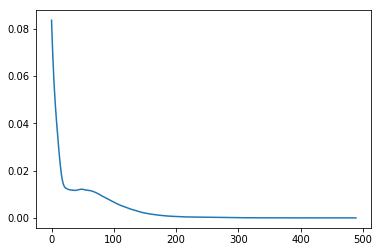

In [39]:
plt.plot([loss_history[i-10] - loss_history[i] for i in range(10, len(loss_history))])

In [49]:
[loss_history[i-10] - loss_history[i] for i in range(10, len(loss_history))][295]

0.00010382127876835956

In [50]:
1e-4

0.0001

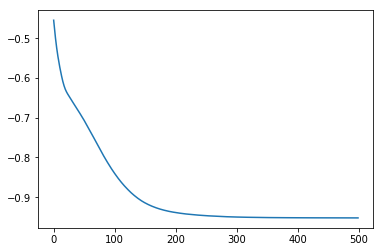

In [19]:
log_loss = np.log10(loss_history)
plt.figure()
plt.plot(log_loss)
plt.show()

In [25]:
int(round(true_distance.max()))

5

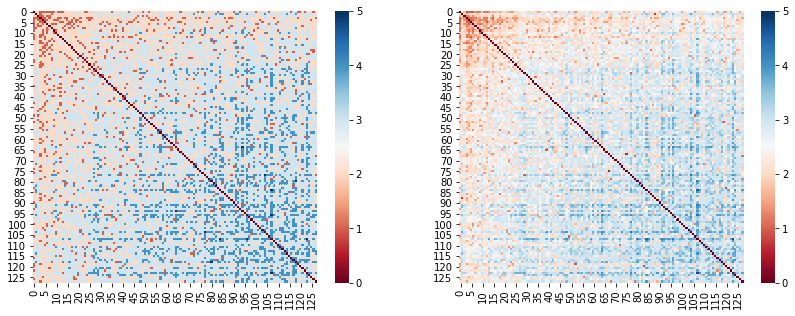

In [26]:
plt.figure(figsize=(14,5))

true_distance = squareform(obj_distances)
plt.subplot(121)
sns.heatmap(true_distance, cmap='RdBu', vmax=int(round(true_distance.max())))

pred_distance = squareform(embed_distances)
plt.subplot(122)
sns.heatmap(pred_distance, cmap='RdBu', vmax=int(round(true_distance.max())))

In [4]:
def cdist(X, Y):
    X2 = tf.reduce_sum(tf.square(X), 1)
    Y2 = tf.reduce_sum(tf.square(Y), 1)
    X2 = tf.reshape(X2, [-1, 1])
    Y2 = tf.reshape(Y2, [1, -1])
    # return pairwise euclidead difference matrix
    distances = tf.sqrt(tf.maximum(
        X2 + Y2 - 2 * tf.matmul(X, Y, False, True), 0.0))
    assert distances.shape == [X.shape[0], Y.shape[0]]
    return distances

In [5]:
def compute_T(K, u, v, n_iter, tol):
    """
    Parameters:
    -----------
        D: 2D array, [M, N]
        r: 1D array, [M, ]
        c: 1D array, [N, ]
        lambd: regularization parameter in Sinkhorn divergence
        p: power of the Wasserstein space
        n_iter: number of iterations for matrix balancing
        tol: tolerance for stopping matrix balancing iterations
    """
    r = tf.random.uniform([int(u.shape[0]), 1], dtype=tf.float64)
    c = tf.random.uniform([int(v.shape[0]), 1], dtype=tf.float64)
    r_new = tf.negative(tf.ones([int(u.shape[0]), 1], dtype=tf.float64))
    c_new = tf.negative(tf.ones([int(v.shape[0]), 1], dtype=tf.float64))

    def cond(r, c, r_new, c_new):
        r_enter = tf.reduce_any(tf.abs(r_new - r) > tol)
        c_enter = tf.reduce_any(tf.abs(c_new - c) > tol)
        return tf.logical_or(r_enter, c_enter)

    def body(r, c, r_new, c_new):
        r, c = r_new, c_new
        r_new = u / tf.matmul(K, c, False, False)
        c_new = v / tf.matmul(K, r_new, True, False)
        return [r, c, r_new, c_new]

    _, _, r, c = tf.while_loop(cond, body, [r, c, r_new, c_new], maximum_iterations=n_iter)

    T_opt = tf.matmul(tf.diag(tf.reshape(r, (-1,))),
                      tf.matmul(K, tf.diag(tf.reshape(c, (-1,)))))

    return T_opt

In [6]:
def wasserstein_distance(n1, n2, embeddings, u, v, lambd, p, n_iter, tol):
    support_1 = embeddings[n1, :, :]
    support_2 = embeddings[n2, :, :]
    D = cdist(support_1, support_2)
    D_p = tf.pow(D, p)
    K = tf.exp(-D_p / lambd)
    T = compute_T(K, u, v, n_iter, tol)

    # distance = tf.trace(tf.matmul(D_p, T, False, True)) + lambd * \
    #     tf.trace(tf.matmul(T, tf.log(T) -
    #                        tf.ones(T.shape, dtype=tf.float64), False, True))
    distance = tf.trace(tf.matmul(D_p, T, False, True))
    return distance

In [7]:
def embedding_distances(pairs, embeddings, u, v, lambd, p, n_iter, tol):

    results = tf.map_fn(lambda x: wasserstein_distance(
        x[0], x[1], embeddings, u, v, lambd, p, n_iter, tol), (pairs), dtype=tf.float64)
    return results

In [8]:
def train(node_pairs, obj_distances, n_epochs=500, patience=10, learning_rate=0.1, u_v=None, nodes=128, embed_dim=20, ground_dim=2, lambd=0.1, p=1, mat_bal_iter=20, mat_bal_tol=1e-5):
    if u_v is None:
        u = tf.ones([embed_dim, 1], dtype=tf.float64) / embed_dim
        v = tf.ones([embed_dim, 1], dtype=tf.float64) / embed_dim
    
    n_nodes = int(obj_distances.shape[0])

    Node_Pairs = tf.placeholder(dtype=tf.int32, shape=[n_nodes, 2], name='Node_Pairs')
    Obj_Distances = tf.placeholder(dtype=tf.float64, shape=[n_nodes], name='Obj_Distances')

    Embeddings = tf.Variable(tf.random.uniform(
        [nodes, embed_dim, ground_dim], dtype=tf.float64), name='Embeddings')
    Embed_Distances = embedding_distances(Node_Pairs, Embeddings, u, v, lambd, p, mat_bal_iter, mat_bal_tol)
    Loss = tf.reduce_mean(tf.abs(Embed_Distances - Obj_Distances) / Obj_Distances)
    Jac = tf.gradients(ys=Embed_Distances, xs=Embeddings)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(Loss)
    init_op = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init_op)
        # Lists for storing the changing Cost and Accuracy in every Epoch
        loss_history = []

        best_loss = 1000
        early_stopping_counter = 0
        for epoch in range(n_epochs):
           # Running the Optimizer
            _, embeddings, embed_distances, loss, jac = sess.run([optimizer, Embeddings, Embed_Distances, Loss, Jac], feed_dict={Node_Pairs: node_pairs, Obj_Distances: obj_distances})
            # Storing loss to the history
            loss_history.append(loss)
            # Displaying result on current Epoch
            # if epoch % 10 == 0 and epoch != 0:
            logging.info("Epoch: {}/{}, loss: {}".format(epoch, n_epochs, loss))
            # Early stopping check
            if loss < best_loss:
                best_loss = loss
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
            if early_stopping_counter >= patience:
                break
    return embeddings, loss_history, embed_distances, jac

In [9]:
from graph_generator import GraphGenerator

g = GraphGenerator(graph_type='scale-free', n_nodes=128, m=3)
node_pairs = g.get_node_pairs()
print(node_pairs.shape)
obj_distances = g.get_obj_distances()
print(obj_distances.shape)

(8128, 2)
(8128,)


In [65]:
import networkx as nx

In [27]:
np.savez('example', embeddings=embeddings, loss=loss_history, embed_distances=embed_distances)

In [28]:
data = np.load('example.npz')

In [30]:
(data['embeddings'] == embeddings).all()

True

In [31]:
(data['loss'] == np.array(loss_history)).all()

True

In [32]:
(data['embed_distances'] == embed_distances).all()

True

In [33]:
import os

In [34]:
os.listdir('./graphs/')

['scale_free_1.pickle',
 'scale_free_10.pickle',
 'scale_free_11.pickle',
 'scale_free_12.pickle',
 'scale_free_13.pickle',
 'scale_free_14.pickle',
 'scale_free_15.pickle',
 'scale_free_16.pickle',
 'scale_free_17.pickle',
 'scale_free_18.pickle',
 'scale_free_19.pickle',
 'scale_free_2.pickle',
 'scale_free_20.pickle',
 'scale_free_3.pickle',
 'scale_free_4.pickle',
 'scale_free_5.pickle',
 'scale_free_6.pickle',
 'scale_free_7.pickle',
 'scale_free_8.pickle',
 'scale_free_9.pickle']